In [1]:
## For debbugging
%load_ext autoreload

In [2]:
# import os
import sys
from pathlib import Path
module_path = Path('.').resolve().parents[0]
if module_path not in sys.path:
    sys.path.append(str(module_path))


In [3]:
## for debugging:
# %aimport mlp.keyword
# %aimport mlp.tools
%aimport mlp.kex
%aimport app.test_app
# %aimport mlp.tree
%autoreload 1
from mlp.kex import *


In [4]:
import numpy as np
import pandas as pd
import seaborn as sns
import re
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook, tqdm
%matplotlib inline

In [5]:
import dask.dataframe as dd
import dask
import string
from fuzzywuzzy import process as zz


data_dir = module_path/'data'/'mine_data'
df = dd.read_csv(data_dir/'loader_work_orders_sanitised.csv')

# data_dir = module_path/'data'/'gs_data'
# df = dd.read_csv(data_dir/'Maintenance_All_Clean.csv')

# data_dir = module_path/'data'/'arm_data'
# cols = [2,3,4,5,6,8,9,10,13,14]
# df = dd.read_csv(data_dir/'line_data_timed.csv', usecols=cols, 
#                  parse_dates={'date':[4]}, thousands=',', infer_datetime_format=True)
# names = df.columns.str.lower().str.replace('[^\w\s]','').str.replace(' ', '_').tolist()
# names[-1] = 'scrap_comments'
# df.columns = names

# df = df.drop(df[(df.commodity == 'D. Day')|(df.commodity == 'D. DAY')].index, axis=1)
# df = dd.read_csv(data_dir/'line_data_timed.csv')



gs_nlp_select = NLPSelect(columns = ['Description', 'Resolution'])
m_nlp_select = NLPSelect(columns='ShortText')
arm_nlp_select = NLPSelect(columns=['scrap_reason','scrap_comments'])

# raw_text = gs_nlp_select.transform(df)#.compute()
raw_text = m_nlp_select.transform(df)
# raw_text = arm_nlp_select.transform(df)#.compute()

# raw_text.compute()

### Build Vocab

In [6]:
tex = TokenExtractor()
toks = tex.fit_transform(raw_text)
print(tex.vocab_)

['replace' 'repair' 'service' ... 'exo' 'vactruck' '1981']


In [7]:
toks.toarray()[0,:].sum()

1.9516876788888666

In [8]:
vocab = tex.annotation_assistant(data_dir/'mine_vocab_app.csv', gui=False)

### Extract Keywords

In [9]:

# vocab = pd.read_csv(data_dir/'app_vocab_mike.csv', index_col=0)
# how many instances of each keyword class are there?
print('named entities: ')
print('I\tItem\nP\tProblem\nS\tSolution\nR\tRedundant')
print('U\tUnknown\nX\tStop Word')
print('total tokens: ', vocab.NE.notna().sum())
print('total tags: ', vocab.groupby("NE").nunique().alias.sum())
vocab.groupby("NE").nunique()

named entities: 
I	Item
P	Problem
S	Solution
R	Redundant
U	Unknown
X	Stop Word
total tokens:  104
total tags:  17


,NE,alias,notes,score
NE,,,,
I,1,8,0,30
P,1,1,0,9
S,1,5,0,59
U,1,3,0,6


In [10]:
# # vocab.loc['replaced',:]
tag_df = pd.DataFrame(index=range(len(raw_text)))
for query in (vocab.alias.unique()):
#     query = 'hydraulic'
#     vocab[vocab.alias==query].index.tolist()
    query_idx = [tex._model.vocabulary_[i] for i in vocab[vocab.alias==query].index.tolist()]
    tag_df[query] = ((toks[:,query_idx]).toarray() > 0).any(axis=1).astype(int)


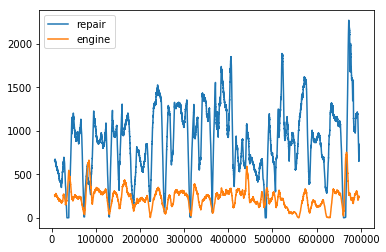

In [24]:
sample_tag = tag_df.T[tag_df.T[6].astype(bool)].T

# motor_pump.set_index(df.index)
# .rolling(1000).sum()
sample_tag.rolling(sample_tag.shape[0]//100).sum().plot()
# df.resample()

### 2-grams

In [143]:
thes_dict = vocab[vocab.alias.notna()].alias.to_dict()
substr = sorted(thes_dict, key=len, reverse=True)
# matcher = lambda s: r'\b'+re.escape(s)+r'\b'
# matcher = lambda s: re.escape(s)
rx = re.compile(r'\b(' + '|'.join(map(re.escape, substr))+ r')\b')
clean_text = raw_text.str.replace(rx, lambda match: thes_dict[match.group(0)])
clean_text.compute()[:4]
# TfidfVectorizer()
# '(?u)\\b\\w\\w+\\b'

0                       broken bar feeder chain repair
1    no power replace pin in pendant and powered ma...
2    smartscope harness broken part order   tech re...
3                  check   charge accumulator where ok
dtype: object

In [144]:
from itertools import combinations, permutations, product
tex2 = TokenExtractor(ngram_range = (2,2))
#                       vocabulary=[' '.join(i) for i in combinations(vocab[vocab.alias.notna()].alias.unique(), 2)])
toks2 = tex2.fit_transform(clean_text)
print(tex2.vocab_)
voc2 = tex2.annotation_assistant(data_dir/'app_2g_vocab_mike.csv', gui=False)

['hydraulic leak' 'chip conveyor' 'accumulator check' ... 'r972 copied'
 'reading did' 'programming parameters']


In [145]:
NE_dict = vocab.NE.fillna('U').to_dict()
NE_dict.update(vocab.fillna('U').reset_index()[['NE', 'alias']].drop_duplicates().set_index('alias').NE.to_dict())
NE_sub = sorted(NE_dict, key=len, reverse=True)

# matcher = lambda s: r'\b'+re.escape(s)+r'\b'
# matcher = lambda s: re.escape(s)
NErx = re.compile(r'\b(' + '|'.join(map(re.escape, NE_sub))+ r')\b')
NE_text = voc2.index.str.replace(NErx, lambda match: NE_dict[match.group(0)])
voc2.loc[:,'NE'] = NE_text.tolist()



# g = vocab.groupby('alias')
# for one_grams in voc2.index.str.split().tolist():
#     for one_gram in one_grams:
#         try:
#             print(g.get_group(one_gram).NE[0])
#         except KeyError:
#             pass

In [147]:
NE_map = {' '.join(i):'' for i in product('IPSUX', repeat=2)}

NE_map['I I'] = 'I'
NE_map['S I'] = 'S I'
NE_map['P I'] = 'P I'

NE_map['I S'] = 'S I'
NE_map['I P'] = 'P I'

NE_map['S S'] = 'X'
NE_map['P P'] = 'X'
NE_map['S P'] = 'X'
NE_map['P S'] = 'X'
# NE_map['']
voc2['NE'] = voc2.NE.apply(lambda x: NE_map[x])
# voc2_est.to_csv('test_estimated_2g.csv')
# voc2_est[(voc2_est!='') & (voc2_est!='X')]
voc2['score'] = tex2.scores_
# voc2.NE

# OLD

In [138]:
# tqdm.pandas(desc="KEx")
from sklearn.feature_extraction import stop_words
 
# print(stop_words.ENGLISH_STOP_WORDS)

thes_dict = vocab[vocab.alias.notna()].alias.to_dict()
substr = sorted(thes_dict, key=len, reverse=True)
rx = re.compile('|'.join(map(re.escape, substr)))

toks = raw_text.str.split()
toks = toks.apply(lambda d: d if isinstance(d, list) else [], 
                             meta=toks)

tags = raw_text.str.replace(rx, lambda match: thes_dict[match.group(0)]).str.split()
tags = tags.apply(lambda d: d if isinstance(d, list) else [], 
                             meta=tags)

grps = vocab.groupby('NE')

# have to pre-allocate column names...dask doesn't like loops :(
tagI = tags.apply(lambda x: list(set(grps.get_group('I')['alias'].astype(str).tolist()) & set(x)),
                  meta=('I', object)).str.join(', ')
tagP = tags.apply(lambda x: list(set(grps.get_group('P')['alias'].astype(str).tolist()) & set(x)),
                  meta=('P', object)).str.join(', ')
tagS = tags.apply(lambda x: list(set(grps.get_group('S')['alias'].astype(str).tolist()) & set(x)),
                  meta=('S', object)).str.join(', ')

tagU = toks.apply(lambda x: list(set(x) - set(vocab.index) - set(stop_words.ENGLISH_STOP_WORDS)),
                  meta=('U', object)).str.join(', ')

ndf = dd.concat([ tagI, tagP, tagS, tagU], axis=1)


/home/tbsexton/anaconda3/lib/python3.6/site-packages/dask/dataframe/multi.py:571: UserWarning: Concatenating dataframes with unknown divisions.
We're assuming that the indexes of each dataframes are 
aligned. This assumption is not generally safe.
  warn("Concatenating dataframes with unknown divisions.\n"


In [139]:
from dask.diagnostics import ProgressBar, Profiler, ResourceProfiler, CacheProfiler, visualize
from dask.distributed import Client
import dask

## multiproc, not thread, due to GIL with text. 
with Profiler() as prof, ResourceProfiler(dt=0.25) as rprof, CacheProfiler() as cprof:
    with ProgressBar(), dask.set_options(get=dask.multiprocessing.get):
        tag_df=ndf.compute()

# visualize([prof, rprof, cprof])
tag_df.head()

[########################################] | 100% Completed |  3.5s


,I,P,S,U
0,"chain, feeder",broken,repair,
1,"machine, cable, pendant, pin",short,replace,
2,part,broken,"order, repair",
3,accumulator,,"ok, charge, check",
4,"attachment, saw, hydraulic",leak,replace,


In [140]:
tag_df['og'] = raw_text
tag_df

,I,P,S,U,og
0,"chain, feeder",broken,repair,,broken bar feeder chain repaired
1,"machine, cable, pendant, pin",short,replace,,no power replaced pin in pendant and powered m...
2,part,broken,"order, repair",,smartscope harness broken parts ordered tech...
3,accumulator,,"ok, charge, check",,check charge accumulators where ok
4,"attachment, saw, hydraulic",leak,replace,,hyd leak at saw atachment replaced seal in saw...
5,"unit, thread",,"setup, complete",,cs1008 setup change over from arc1004 comple...
6,"saw, gear, shelf, attachment, person, unit",,"remove, replace, rebuild",,gears on saw attachment tight and grinding per...
7,accumulator,,"charge, check",,check and charge accumulators checked and charged
8,"mill, spindle, station",,repair,,st 14 milling spindle repairs reapired
9,"line, hydraulic","rupture, leak",replace,b,hydraulic leak replaced ruptured hydraulic lin...


In [16]:
# nlp_cols = ['Description', 'Resolution']
# nlp_cols=0
# raw_text = df.iloc[:,nlp_cols].fillna('').add(' ').sum(axis=1).str[:-1]

# raw_text = raw_text.str.lower()
# raw_text.str.replace('\n', ' ')
# raw_text = raw_text.str.replace('[{}]'.format(string.punctuation), ' ')

def series_itervals(s):
    for n, val in s.iteritems():
        yield val
# raw_text.compute()

In [28]:
from sklearn.feature_extraction.text import TfidfVectorizer

# vec = TfidfVectorizer(input='content', 
#                       ngram_range=(1,1),
#                       stop_words='english',
# #                       min_df=2, 
# #                       max_df=0.95,
#                       sublinear_tf=True,
#                       smooth_idf=False,
# #                       max_features=3000
#                      )

# tf = vec.fit(tqdm(series_itervals(raw_text)))


In [18]:
# tf = vec.transform(series_itervals(raw_text))  # CSR sparse array
# tf = tf.toarray()
tf.shape

(696211, 29422)

[('replace', 28671.656586049528),
 ('repair', 23315.672519843509),
 ('service', 18459.533601779585),
 ('oil', 12036.019749034887),
 ('leak', 11195.783407141291),
 ('inspection', 10932.103424049106),
 ('lube', 10514.25589025008),
 ('change', 10369.942455284563),
 ('air', 10333.877317125754),
 ('mechanical', 9512.6087999818319),
 ('engine', 9100.656635962685),
 ('lubrication', 9045.2935483057063),
 ('pm', 9004.4377757877755),
 ('hose', 8688.7022881740795),
 ('pump', 7257.4747167787609),
 ('brake', 7202.1964601366071),
 ('weekly', 7112.7785995961667),
 ('working', 7085.7028709121887),
 ('fault', 6908.7969158723181),
 ('repairs', 6648.2767971289823),
 ('check', 6523.6572009770825),
 ('lights', 6275.9485485594041),
 ('leaking', 6042.0799142608612),
 ('broken', 5316.8478967504361),
 ('start', 5230.6273081447243),
 ('hyd', 5222.4485127463586),
 ('light', 5192.9811273116611),
 ('inspections', 5050.1307590726065),
 ('pos', 4817.8297036323047),
 ('grease', 4804.9494999201734),
 ('changeout', 477

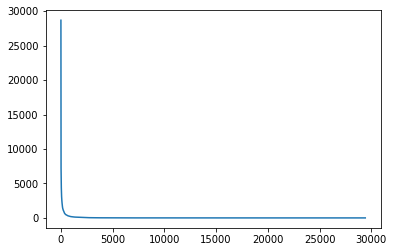

In [24]:
# sort = vec.idf_.argsort()
tf_tot = np.array(tf.sum(axis=0))[0]
sort = tf_tot.argsort()[::-1]

# np.array(vec.get_feature_names())[sort]
plt.plot(tf_tot[sort])
list(zip(np.array(vec.get_feature_names())[sort], tf_tot[sort]))


In [16]:
from numba import jit
import scipy.constants as cnst

# http://cse.iitkgp.ac.in/~pabitra/paper/stemmer.pdf
# @jit
# np.not_equal()

def str_D1(str1,str2, reg=None):
    if reg is None:
        reg = cnst.golden**(-np.arange(str1.shape[0]))
    ser = np.char.not_equal(str1,str2)*reg    
    return ser.sum()

def roll_D1(str1,str2, reg=None):
    if reg is None:
        reg = cnst.golden**(-np.arange(str1.shape[0]))
    ser = np.char.not_equal(str1,str2)*reg    
    
    left=np.roll(str1,1)
    ser_left = np.char.not_equal(left[1:], str2[:-1])*reg[1:]
    right = np.roll(str1,-1)
    ser_right = np.char.not_equal(left[:-1], str2[1:])*reg[1:]
    
    return ser.sum()*(ser_right.sum()+ser_left.sum())

In [17]:
first_zero = lambda l: next((i for i, x in enumerate(l) if x), None) # x!= 0 for strict match

def str_D2(str1,str2):
    lgth = max(len(str1[0]), len(str2[0]))
#     print(lgth)
    a = str1[0].ljust(lgth)
    b = str2[0].ljust(lgth)
    
    ser = [int(i!=j) for i,j in zip(a,b)]
    m = first_zero(ser)
    if (m is not None) and m>0:
        geo_sum = (1-0.5**(lgth-m+1))/(1-0.5)  # \sum_{i=m}^n 1/2^{i-m}
        return geo_sum/m 
    else:
        return 100.

def str_D3(str1,str2):
    lgth = max(len(str1), len(str2))
#     print(lgth)
    a = str1[0].ljust(lgth)
    b = str2[0].ljust(lgth)
    
    ser = [int(i!=j) for i,j in zip(a,b)]
    m = first_zero(ser)
    if (m is not None) and m>0:
        geo_sum = (1-0.5**(lgth-m+1))/(1-0.5)  # \sum_{i=m}^n 1/2^{i-m}
        return (lgth-m)*geo_sum/m 
    else:
        return 100.
    
def str_D4(str1,str2):
    lgth = max(len(str1), len(str2))
#     print(lgth)
    a = str1[0].ljust(lgth)
    b = str2[0].ljust(lgth)
    
    ser = [int(i!=j) for i,j in zip(a,b)]
    m = first_zero(ser)
    geo_sum = (1-0.5**(lgth-m+1))/(1-0.5)  # \sum_{i=m}^n 1/2^{i-m}
    return (lgth-m)*geo_sum/lgth 
    
pd.to_    

In [21]:
strs = np.array(vec.get_feature_names())[sort]
# chars = np.zeros((len(strs), max(len(i) for i in strs)), dtype='unicode_')
# for n,i in enumerate(strs):
#     chars[n, :len(i)] = list(i)
# chars.shape

In [23]:
# http://scikit-learn.org/stable/faq.html#how-do-i-deal-with-string-data-or-trees-graphs
from fuzzywuzzy import process, fuzz
process.extractBests('replace', strs, limit=20, score_cutoff=75)
# process.extract()
# fuzz.WRatio()

# X = np.arange(chars.shape[0]).reshape(-1, 1)  # index look-up
# def str_dist(x,y, reg=None):
#     i,j = int(x[0]), int(y[0])  # extract indices
#     return str_D1(chars[i], chars[j], reg=reg)

[('replace', 100),
 ('replaced', 93),
 ('replacer', 93),
 ('replacel', 93),
 ('rreplace', 93),
 ('replaces', 93),
 ('repalace', 93),
 ('repplace', 93),
 ('rerplace', 93),
 ('reaplace', 93),
 ('1replace', 93),
 ('treplace', 93),
 ('replkace', 93),
 ('reeplace', 93),
 ('replacet', 93),
 ('replaace', 93),
 ('replace5', 93),
 ('replace4', 93),
 ('replacew', 93),
 ('replace3', 93)]

In [163]:
from sklearn.cluster import DBSCAN
clust = DBSCAN(metric=str_dist, eps=.25, n_jobs=-1).fit(X)

grps = pd.DataFrame(index=strs,data=dict(cls=clust.labels_, score=tf_tot[sort][:2000]))
g = grps[grps.cls!=-1].groupby('cls')

grps['score_best'] = grps['score']
grps.loc[grps.cls!=-1,'score_best'] = g['score'].transform(max)
grps.sort_values(['score_best', 'score'], ascending=False).to_csv('clust_vocab_mine.csv', sep='\t')

## Deprecated

In [146]:
from scipy.spatial import distance

# reg=cnst.golden**(-np.arange(X.shape[1]))
# %lprun -f str_D1 distance.pdist(X[:100], str_D1)
distance.squareform(distance.pdist(X[:100], str_D1))

array([[ 0.        ,  0.52786405,  1.76393202, ...,  2.52786405,
         2.52786405,  2.52786405],
       [ 0.52786405,  0.        ,  1.76393202, ...,  2.47213595,
         2.52786405,  2.47213595],
       [ 1.76393202,  1.76393202,  0.        , ...,  2.52786405,
         2.52786405,  2.52786405],
       ..., 
       [ 2.52786405,  2.47213595,  2.52786405, ...,  0.        ,
         2.52786405,  2.47213595],
       [ 2.52786405,  2.52786405,  2.52786405, ...,  2.52786405,
         0.        ,  2.29179607],
       [ 2.52786405,  2.47213595,  2.52786405, ...,  2.47213595,
         2.29179607,  0.        ]])

In [147]:


# sns.clustermap(distance.squareform(distance.pdist(np.array(strs).reshape(-1,1), str_D1)),
#                yticklabels=strs, figsize=(15,20))
dist_mat = pd.DataFrame(data=distance.squareform(distance.pdist(X, str_D1)), 
             index=strs, columns = strs)

/home/tbsexton/anaconda3/lib/python3.6/site-packages/seaborn/matrix.py:603: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  metric=self.metric)


accumulator     0.000000
accumulators    0.005025
accrepair       0.604878
access          0.604878
acc             0.604878
accessory       0.604878
accident        0.604878
actuator        0.750776
ac              0.986844
acond           0.986844
Name: accumulator, dtype: float64

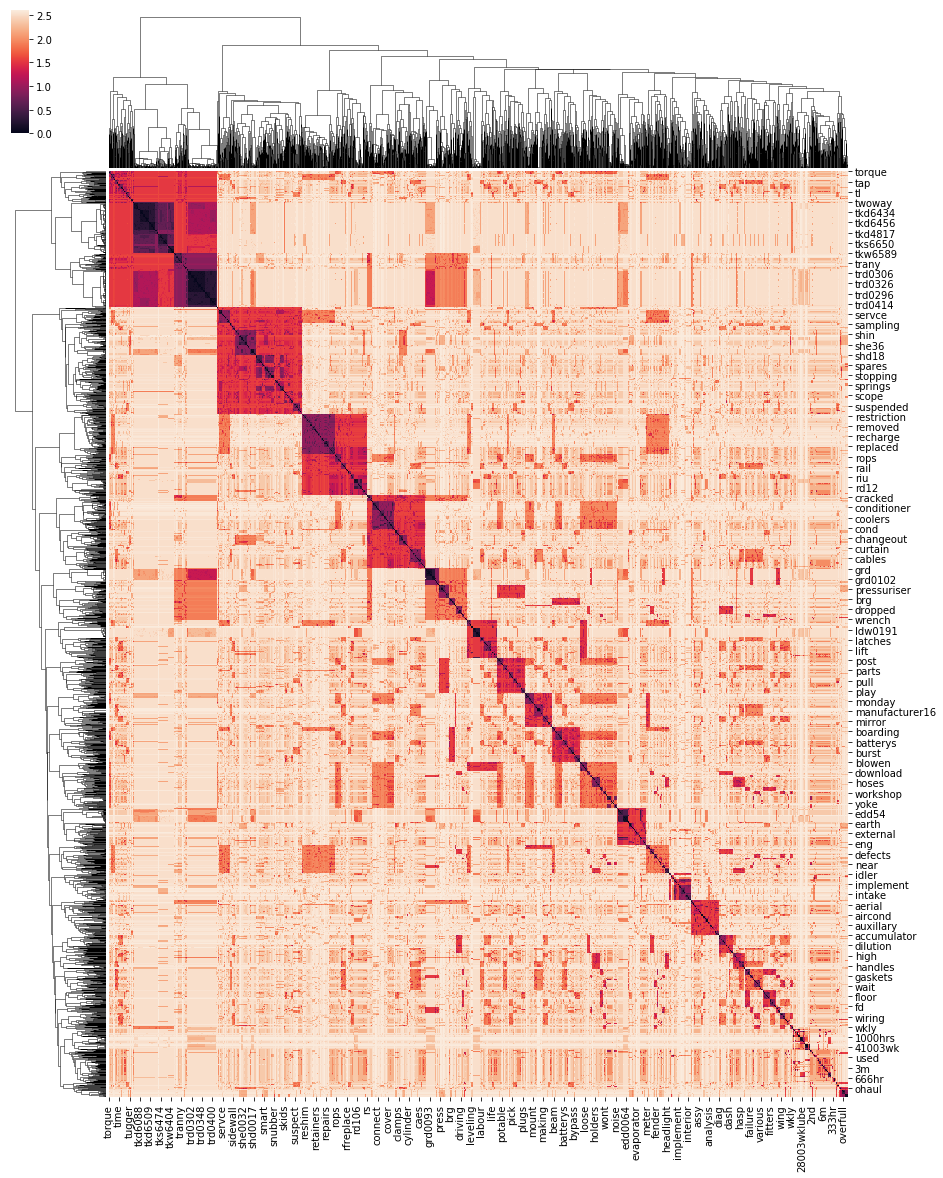

In [148]:
sns.clustermap(dist_mat,
               figsize=(15,20))

dist_mat['accumulator'].sort_values()[:10]

In [150]:
import pprint
from sklearn.cluster import DBSCAN
clust = DBSCAN(metric='precomputed', eps=.25).fit(dist_mat)

grps = pd.DataFrame(index=dist_mat.index,data=dict(cls=clust.labels_, score=tf_tot[sort][:2000]))
g = grps[grps.cls!=-1].groupby('cls')

grps['score_best'] = grps['score']
grps.loc[grps.cls!=-1,'score_best'] = g['score'].transform(max)
grps.sort_values(['score_best', 'score'], ascending=False).to_csv('clust_vocab_mine.csv', sep='\t')

In [218]:
from nltk.metrics.distance import edit_distance
# metrics.distance.edit_distance('abcde','abcfg')
ed_func = lambda x,y: edit_distance(x[0], y[0])
dist_mat = pd.DataFrame(data=distance.squareform(distance.pdist(np.array(strs).reshape(-1,1), 
                                                                ed_func)), 
             index=strs, columns = strs)
dist_mat['accumulator'].sort_values()[:10]

accumulator    0.0
contactor      7.0
motor          7.0
completed      7.0
operator       7.0
conveyor       8.0
clamp          8.0
coolant        8.0
filter         8.0
rebuilt        8.0
Name: accumulator, dtype: float64

In [230]:
vec_mat = vec.transform(series_itervals(raw_text)).toarray().T
dist_mat = pd.DataFrame(data=distance.squareform(distance.pdist(vec_mat,'cosine')), 
             index=strs, columns = strs)
dist_mat['accumulator'].sort_values()[:10]

accumulator    0.000000
check          0.322233
30bar          0.376422
charged        0.413130
requested      0.529558
charge         0.685735
lp             0.701154
25bar          0.723847
tag            0.729880
ok             0.746831
Name: accumulator, dtype: float64

In [11]:
for fname in data_dir.glob('TEMP_init-*.txt'):
    print(fname)

E:\Thurston\Documents\Code\Pycharm\ml-py\data\gs_data\TEMP_init-0.txt


In [129]:
# docs = textacy.fileio.read.read_csv(str(data_dir/'TEMP_init-0.txt'))
# Descriptions in RawText col
# content_stream, metadata_stream = textacy.fileio.split_record_fields(docs, 1)  

corpus = textacy.Corpus(u'en')

for fname in data_dir.glob('TEMP_init-*.txt'):
    print(fname)
    docs = textacy.fileio.read.read_csv(str(fname), delimiter='\t')
    content_stream, _ = textacy.fileio.split_record_fields(docs, 0)  
    corpus.add_texts(content_stream)

/home/tbsexton/Documents/Projects/DiagnosticKB/MaintenanceLanguageProcessing/data/gs_data/TEMP_init-0.txt


In [144]:
vsm = textacy.vsm.Vectorizer(weighting='tfidf',
                             normalize=False,
                             smooth_idf=False,
                             sublinear_tf=True,
                             min_df=2, max_df=0.95)  # each token in >2 docs, <95% of docs

terms_list = (doc.to_terms_list(ngrams=(1, 2, 3),
                                normalize=u'lemma',
                                named_entities=False,
                                filter_stops=True,  # Nope! Not needed :)
                                filter_punct=True,
                                as_strings=True) for doc in corpus)
doc_term_mat = vsm.fit_transform(terms_list)
doc_term_mat

def get_norm_tokens(doc_n, doc_term_mat, id_to_term):
    doc = doc_term_mat[doc_n].toarray()
    # we only care about unique tags, right?
    return set([id_to_term[i] for i in doc.nonzero()[1]])

# list(list(terms_list)[1])

In [145]:
get_norm_tokens(0, doc_term_mat, vsm.id_to_term)

{'bar',
 'bar feeder',
 'bar feeder chain',
 'break',
 'break bar',
 'break bar feeder',
 'chain',
 'feeder',
 'feeder chain',
 'repair'}

In [ ]:
vsm.sublinear_tf()